In [503]:
import torch
from torch import utils, nn

import torch.nn.functional as F

import os

from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty

100%|██████████| 10000/10000 [00:00<00:00, 31704.99it/s]



First 10 samples from the training set:


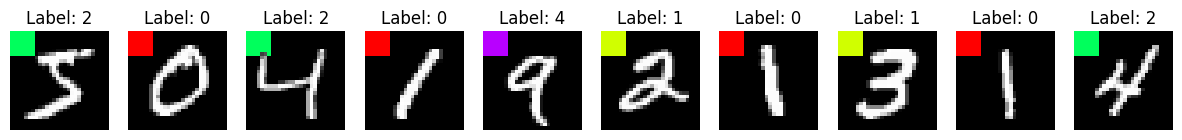


First 10 samples from the test set:


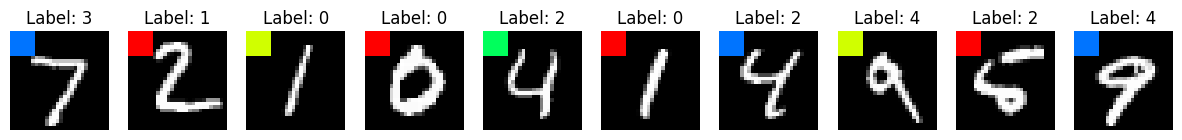

In [504]:

classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
test_classes = classes
# test_classes = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
# difficulty = SpuriousFeatureDifficulty.MAGNITUDE_SMALL
# difficulty = SpuriousFeatureDifficulty.VARIANCE_HIGH
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE
difficulty = SpuriousFeatureDifficulty.VARIANCE_LOW

root_dir = os.path.join(os.getcwd(), 'data/mnist')
root_dir = './data/mnist/'
trainset = SpuCoMNIST(root=root_dir, spurious_feature_difficulty=difficulty, classes=classes, spurious_correlation_strength=0.95, split='train')
trainset.initialize()
testset = SpuCoMNIST(root=root_dir, spurious_feature_difficulty=difficulty, classes=test_classes, spurious_correlation_strength=0.95, split='test')
testset.initialize()


import matplotlib.pyplot as plt
def print_dataset_samples_with_images(dataset, dataset_name, num_samples=10):
    print(f"\nFirst {num_samples} samples from the {dataset_name}:")
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Change to (H, W, C) format for displaying
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Print samples from the training set with images
print_dataset_samples_with_images(trainset, "training set")

# Print samples from the test set with images
print_dataset_samples_with_images(testset, "test set")

In [585]:
from torch.optim import Adam
# from spuco.models import model_factory
# from spuco.robust_train import ERM
# from spuco.utils import Trainer

BATCH_SIZE = 60
NUM_EPOCHS = 12
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE)

# model = model_factory('mlp', (3,28,28), len(classes))
# (3*28*28, len(classes))


In [586]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        # self.pool = nn.MaxPool2d(2, 2)

        self.layer1 = nn.Linear(7*7*64, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)

        self.noncnnlayer1 = nn.Linear(3*28*28, 512)
        self.noncnnlayer2 = nn.Linear(512, 256)
        self.noncnnlayer3 = nn.Linear(256, 128)
        self.noncnnlayer4 = nn.Linear(128, 10)

    def featurizer(self, x):
        # convolution featurizer
        # x = self.conv1(x)
        # x = F.relu(self.batchnorm1(x))
        # x = self.conv2(x)
        # x = F.relu(self.batchnorm2(x))
        # # x = self.pool(x)
        # x = x.view(x.size(0), -1)
        # x = F.relu(self.layer1(x))
        # x = F.relu(self.layer2(x))
        # x = F.relu(self.layer3(x))

        #non convolution featurizer
        x = x.view(x.size(0), -1)
        x = F.relu(self.noncnnlayer1(x))
        x = F.relu(self.noncnnlayer2(x))
        x = F.relu(self.noncnnlayer3(x))
        return x

    def forward(self, x):
        #featurizer
        x = self.featurizer(x)
        #classifier
        # x = self.layer4(x)

        x = self.noncnnlayer4(x)
        return x


In [587]:
def trainingLoop(model, trainDataLoader, lossFunc, optimize, EPOCHS):
    model.train()
    for current_epoch in range(EPOCHS):
        batch = 1
        for batch_inputs, actualClasses in iter(trainDataLoader):
            # batch_inputs = torch.reshape(batch_inputs, [BATCH_SIZE, 3*28*28]) no not even
            # batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
            predicted_outputs = model(batch_inputs)
            current_loss = lossFunc(predicted_outputs, actualClasses)

            if batch % 100 == 0:
                print("currentLoss:",current_loss)

            current_loss.backward()

            optimize.step()
            optimize.zero_grad()
            batch+=1
        print(f"end epoch: {current_epoch + 1}")


def evaluateModel(model, testDataLoader):
    model.eval()
    numCorrect = 0
    numSamples = 0

    for batch_inputs, actual in iter(testDataLoader):
        # print(actual)
        # print(batch_inputs.shape)
        # batch_inputs = torch.reshape(batch_inputs, [BATCH_SIZE, 3*28*28]) no not even
        # batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
        # print(batch_inputs.shape)
        predicted_outputs = model(batch_inputs)
        predicted_classes = predicted_outputs.argmax(axis = 1)
        numCorrect += (predicted_classes == actual).sum().item()
        numSamples += len(batch_inputs)
    accuracy = (numCorrect / numSamples ) * 100


    return accuracy




In [588]:
model = CustomModel()


In [589]:
initialModelResults = evaluateModel(model, test_loader)

In [590]:
trainingLoop(
    model,
    train_loader,
    nn.CrossEntropyLoss(),
    Adam(model.parameters(), lr = 0.0001),
    NUM_EPOCHS
)
# ERM training

currentLoss: tensor(0.1663, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.1286, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0522, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0902, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.3266, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0966, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0837, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0622, grad_fn=<NllLossBackward0>)
end epoch: 1
currentLoss: tensor(0.0616, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.1034, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0137, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0842, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.3210, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0454, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0658, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0484, grad_fn=<NllLossBackward0>)
end epoch: 2
currentLoss: tensor(0.0276, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.

In [591]:
finalModelResults = evaluateModel(model, test_loader)


In [592]:
print("Initial ERM Model Results:", initialModelResults)
print("Final ERM Model Results:", finalModelResults)

Initial ERM Model Results: 19.86
Final ERM Model Results: 88.96


In [593]:
# Grouping data by class
grouped_train_data = {i: [] for i in range(5)}

for inputs, labels in train_loader:
    with torch.no_grad():
        features = model.featurizer(inputs)
        outputs = model(inputs)
        predicted_classes = outputs.argmax(dim=1)

        for input_sample, label, predicted_class, feature in zip(inputs, labels, predicted_classes, features):
            grouped_train_data[predicted_class.item()].append((input_sample, label, feature))

grouped_test_data = {i: [] for i in range(5)}

for inputs, labels in test_loader:
    with torch.no_grad():
        features = model.featurizer(inputs)
        outputs = model(inputs)
        predicted_classes = outputs.argmax(dim=1)

        for input_sample, label, predicted_class, feature in zip(inputs, labels, predicted_classes, features):
            grouped_test_data[predicted_class.item()].append((input_sample, label, feature))


In [594]:
import numpy as np
from sklearn.cluster import KMeans

clustered_train_data = {i: [] for i in range(10)}

for class_label, samples in grouped_train_data.items():
    features = [sample[2].numpy() for sample in samples]
    features = np.stack(features)

    kmeans = KMeans(n_clusters=2)
    cluster_labels = kmeans.fit_predict(features)

    for sample, cluster_label in zip(samples, cluster_labels):
        generated_label = (class_label * 2) + cluster_label
        clustered_train_data[generated_label].append((sample[0], generated_label, class_label))

clustered_test_data = {i: [] for i in range(10)}

for class_label, samples in grouped_test_data.items():
    features = [sample[2].numpy() for sample in samples]
    features = np.stack(features)

    kmeans = KMeans(n_clusters=2)
    cluster_labels = kmeans.fit_predict(features)

    for sample, cluster_label in zip(samples, cluster_labels):
        generated_label = (class_label * 2) + cluster_label
        clustered_test_data[generated_label].append((sample[0], generated_label, class_label))


In [595]:
# for label in clustered_train_data:
#     print(clustered_train_data[label][0][1])
# will only print out the keys

for g_label, samples in clustered_train_data.items():
    for input, generated_label, cluster_label in samples:
        print(f"generated label: {generated_label}, and input shape: {input.shape}")

generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and input shape: torch.Size([3, 28, 28])
generated label: 0, and 

In [596]:
import random

balanced_train_batches = []
size_per_class = BATCH_SIZE // 10

# for class_label in grouped_train_data:
#     print(len(grouped_train_data[class_label]))
smallest_train_group = min(len(clustered_train_data[class_label]) for class_label in grouped_train_data)
num_train_batches = smallest_train_group // size_per_class

for i in range(num_train_batches):
    batch_inputs, batch_labels = [], []
    for class_label in clustered_train_data:
        samples = random.sample(clustered_train_data[class_label], size_per_class)
        inputs, glabels, labels = zip(*samples)

        batch_inputs.extend(inputs)
        batch_labels.extend(glabels)
    batch_inputs_tensor = torch.stack(batch_inputs)
    batch_labels_tensor = torch.tensor(batch_labels)
    balanced_train_batches.append((batch_inputs_tensor, batch_labels_tensor))

print(f"Number of balanced training batches created: {len(balanced_train_batches)}")

balanced_test_batches = []

# for class_label in grouped_train_data:
#     print(len(grouped_train_data[class_label]))
smallest_test_group = min(len(clustered_test_data[class_label]) for class_label in grouped_test_data)
num_test_batches = smallest_test_group // size_per_class

for i in range(num_test_batches):
    batch_inputs, batch_labels = [], []
    for class_label in clustered_test_data:
        samples = random.sample(clustered_test_data[class_label], size_per_class)
        inputs, glabels, labels = zip(*samples)

        batch_inputs.extend(inputs)
        batch_labels.extend(glabels)
    batch_inputs_tensor = torch.stack(batch_inputs)
    batch_labels_tensor = torch.tensor(batch_labels)
    balanced_test_batches.append((batch_inputs_tensor, batch_labels_tensor))

print(f"Number of balanced testing batches created: {len(balanced_test_batches)}")

Number of balanced training batches created: 409
Number of balanced testing batches created: 113


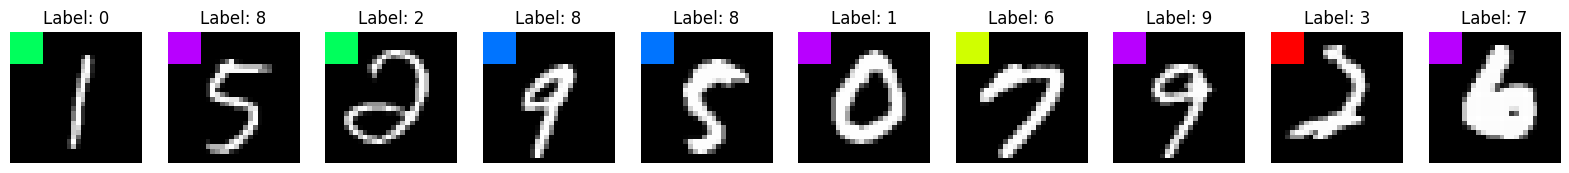

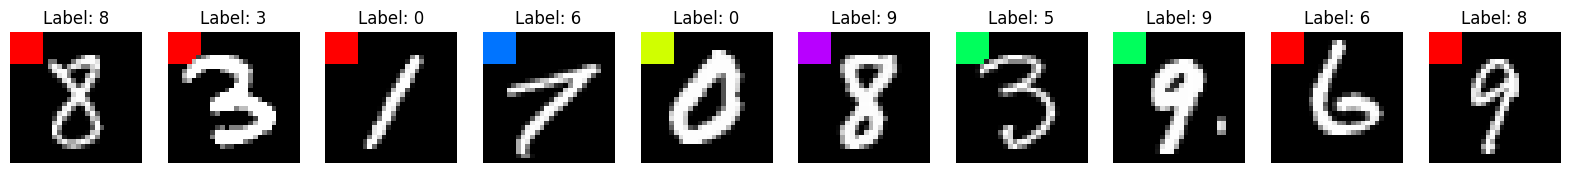

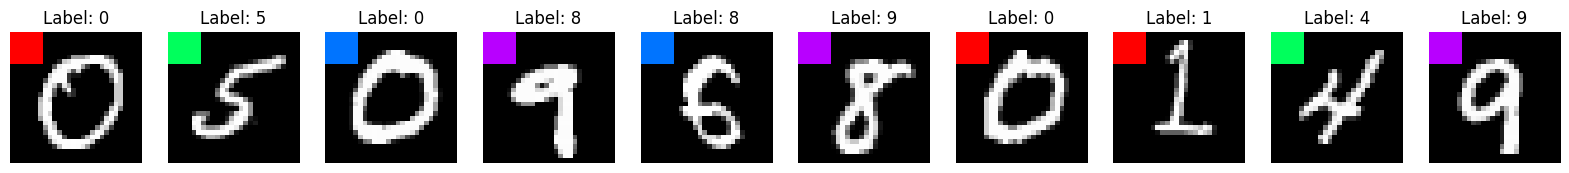

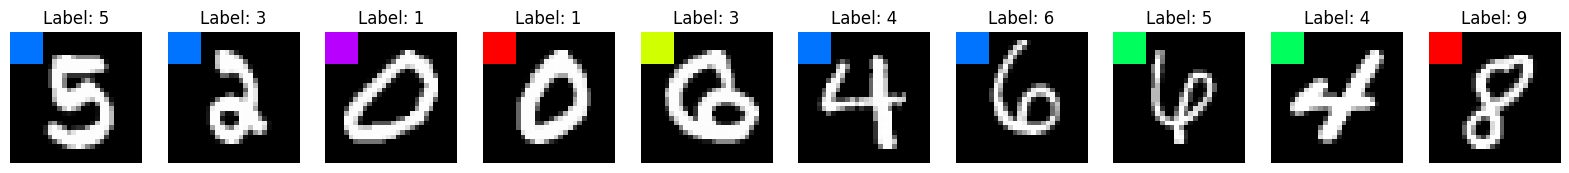

In [597]:
from torch.utils.data import TensorDataset

balanced_training_dataset = TensorDataset(
    torch.cat([batch[0] for batch in balanced_train_batches]),
    torch.cat([batch[1] for batch in balanced_train_batches])
)

balanced_testing_dataset = TensorDataset(
    torch.cat([batch[0] for batch in balanced_test_batches]),
    torch.cat([batch[1] for batch in balanced_test_batches])
)

balanced_train_loader = DataLoader(balanced_training_dataset, BATCH_SIZE)
balanced_test_loader = DataLoader(balanced_testing_dataset, BATCH_SIZE)

import torchvision.transforms as transforms
def print_random_samples(dataloader, num_samples=10):
    all_samples = []
    for batch in dataloader:
        inputs, labels = batch
        for input, label in zip(inputs, labels):
            all_samples.append((input, label))
    num_samples = min(num_samples, len(all_samples))
    random_samples = random.sample(all_samples, num_samples)
    to_pil = transforms.ToPILImage()
    plt.figure(figsize=(num_samples * 2, 2))
    for i, (input, label) in enumerate(random_samples):
        image = to_pil(input)
        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

print_random_samples(balanced_test_loader, 10)
print_random_samples(balanced_test_loader, 10)
print()
print_random_samples(balanced_train_loader, 10)
print_random_samples(balanced_test_loader, 10)

In [601]:
NUM_EPOCHS = 13
newModel = CustomModel()
trainingLoop(
    newModel,
    balanced_train_loader,
    nn.CrossEntropyLoss(),
    Adam(newModel.parameters(), lr = 0.0001),
    NUM_EPOCHS
)
newModelResults = evaluateModel(newModel, balanced_test_loader)

currentLoss: tensor(0.7071, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.4949, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.5176, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.7052, grad_fn=<NllLossBackward0>)
end epoch: 1
currentLoss: tensor(0.3649, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.2886, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.3854, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.5982, grad_fn=<NllLossBackward0>)
end epoch: 2
currentLoss: tensor(0.3102, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.2266, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.3289, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.5251, grad_fn=<NllLossBackward0>)
end epoch: 3
currentLoss: tensor(0.2944, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.1964, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.2812, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.4685, grad_fn=<NllLossBackward0>)
end epoch: 4
currentLoss: tensor(0.2893, grad_fn=<NllLossBackward

In [602]:
# old model retraining
trainingLoop(
    model,
    balanced_train_loader,
    nn.CrossEntropyLoss(),
    Adam(model.parameters(), lr = 0.0001),
    NUM_EPOCHS
)
oldModelRetrainingResults = evaluateModel(model, balanced_test_loader)

currentLoss: tensor(0.0389, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0287, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0470, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0458, grad_fn=<NllLossBackward0>)
end epoch: 1
currentLoss: tensor(0.0424, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0281, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0347, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0441, grad_fn=<NllLossBackward0>)
end epoch: 2
currentLoss: tensor(0.0786, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0110, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0176, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0350, grad_fn=<NllLossBackward0>)
end epoch: 3
currentLoss: tensor(0.0325, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0045, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0189, grad_fn=<NllLossBackward0>)
currentLoss: tensor(0.0240, grad_fn=<NllLossBackward0>)
end epoch: 4
currentLoss: tensor(0.0299, grad_fn=<NllLossBackward

In [604]:
print("Initial ERM Model Results:", initialModelResults)
print("Final ERM Model Results:", finalModelResults)
print("New Model Results:", newModelResults)
print("Old Model Retraining Results:", oldModelRetrainingResults)


Initial ERM Model Results: 19.86
Final ERM Model Results: 88.96
New Model Results: 50.64896755162241
Old Model Retraining Results: 61.533923303834804
